In [2]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


# RNTuple read throughput

In [10]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "numadomains-2numa"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    cores = timedir.split("_")[3].replace("processes","")
    chunks = cores
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        numadomain = int(f.split("_")[3].replace("numa","").replace(".txt",""))
        taskid_local = int(f.split("_")[2].replace("process",""))

        taskid_global = taskid_local if numadomain == 1 else taskid_local + 8
        df["numadomain"] = numadomain
        df["taskid"] = int(taskid_global)
        df["cores"] = int(cores)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by=["cores","taskid"]).reset_index(drop=True)
#with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
df

,taskruntime,taskreadtime,readthroughput,readpayload,numadomain,taskid,cores
0,54.005,9571253172,2949,28235189400,1,0,8
1,51.160,9499772486,2972,28235189400,1,0,8
2,50.401,7096904724,3978,28235189400,1,0,8
3,44.978,7574248748,3727,28235189400,1,0,8
4,48.785,7315073935,3859,28235189400,1,0,8
...,...,...,...,...,...,...,...
211,24.876,7490231409,1884,14117594700,0,15,16
212,22.870,7550063678,1869,14117594700,0,15,16
213,24.113,7636773055,1848,14117594700,0,15,16
214,25.503,7475290503,1888,14117594700,0,15,16


In [11]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / pow(10, 9)
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,8,47.677583,8.161463e+09,3517.194444,2.823519e+10,8.161463
1,16,24.573806,6.564506e+09,2190.444444,1.411759e+10,6.564506


Text(0, 0.5, 'Throughput [MB/s]')

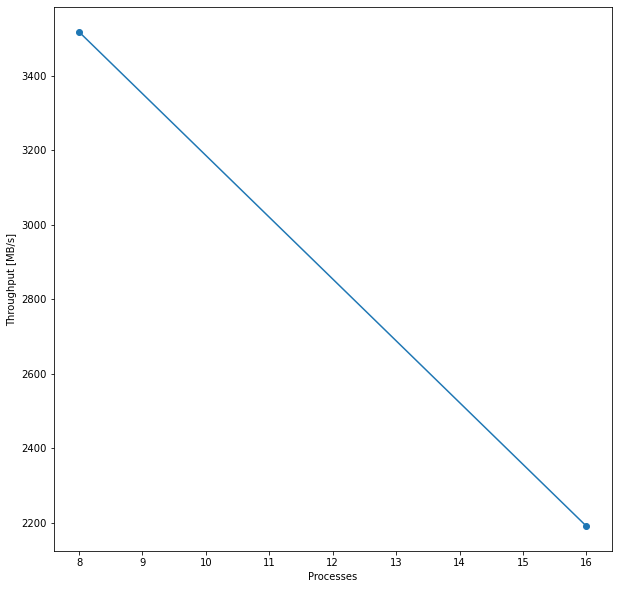

In [12]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

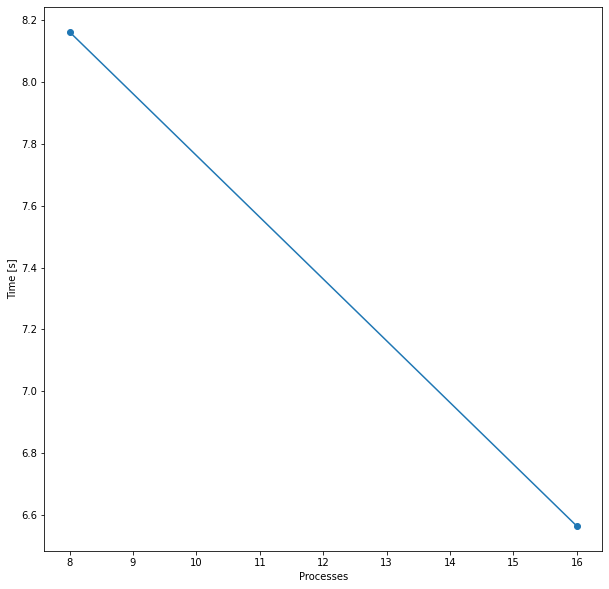

In [13]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [14]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,cores,taskid,taskruntime,taskreadtime,readthroughput,readpayload,numadomain,totalthroughput
0,8,28,381.420667,6.529170e+10,28137.555556,2.258815e+11,8.0,27.478082
1,16,120,393.180889,1.050321e+11,35047.111111,2.258815e+11,8.0,34.225694


Text(0, 0.5, 'Raw IO Throughput [GB/s]')

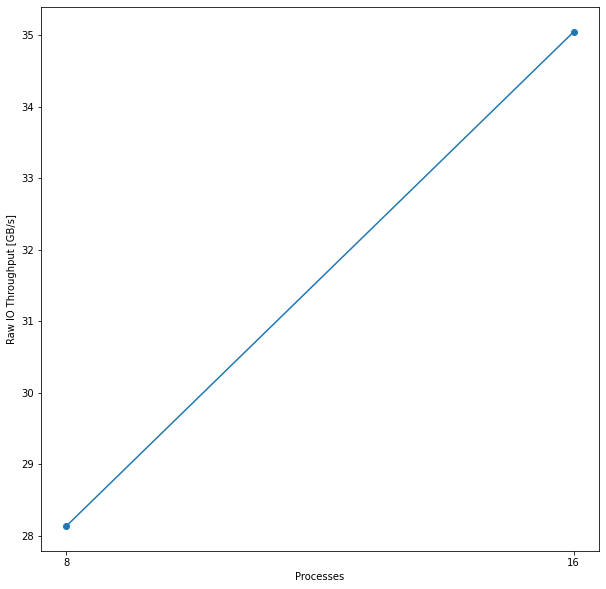

In [15]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Processes")
pyplot.xticks(sumthroughput["cores"])

pyplot.ylabel("Raw IO Throughput [GB/s]")

# TGraph

Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


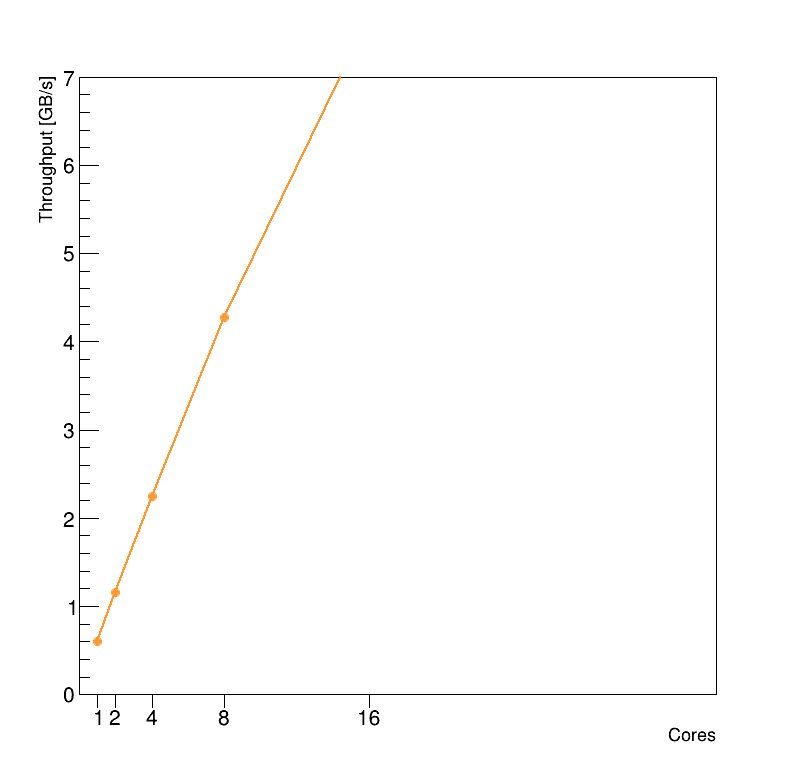

In [32]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 7)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(5):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

In [33]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 17)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.9, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real throughput increase")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

KeyError: 'throughputspeedup'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


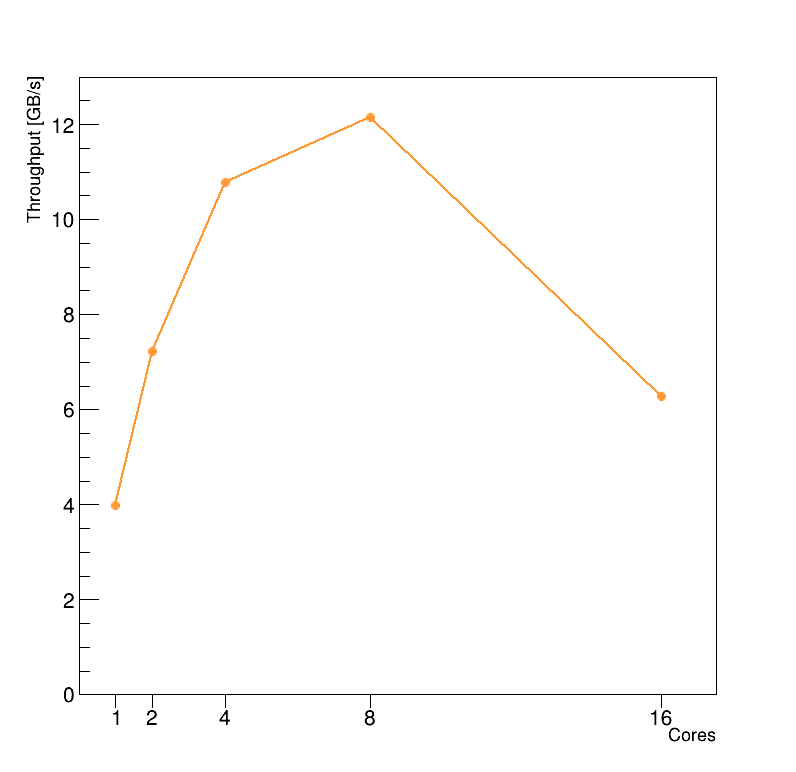

In [150]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")